# Clustering algorithms

## Imports

In [74]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import time

## Global variables

In [63]:
NB_FEATURES = 2
N = 1000
SIZE = 100
DEV = 30
colors = ['r', 'g', 'b', 'y', 'c', 'm']

## Generate dataset

In [48]:
def generate_dataset(nb_features = 10, nb_groups = 6, n = N, size=SIZE, dev=DEV):
    means = np.zeros((nb_groups, nb_features)) # holds the mean of each group
    st_devs = np.zeros((nb_groups, nb_features)) # holds the st_devs of each group
    for i in range(nb_groups):
        for j in range(nb_features):
            means[i][j] = np.random.randint(-size, size)
            st_devs[i][j] = dev*np.random.random()
    data = np.zeros((n, nb_features))
    for i in range(n):
        gi = np.random.randint(0,nb_groups)
        for j in range(nb_features):
            data[i][j] = np.random.normal(loc = means[gi][j], scale = st_devs[gi][j])
    np.save('dummy_data.npy', data)

In [58]:
generate_dataset(nb_features=NB_FEATURES)

In [59]:
data = np.load('dummy_data.npy')

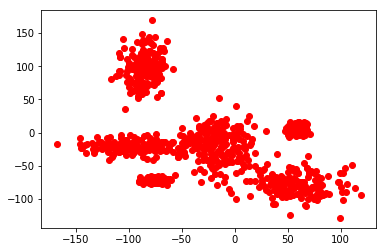

In [60]:
f1 = data[:, 0]
f2 = data[:, 1]
X = np.array(list(zip(f1, f2)))
plt.plot(f1, f2, 'ro')

## Utility functions

In [61]:
# Euclidean Distance Caculator
def dist(a, b, ax=0):
    return np.linalg.norm(a - b, axis=ax)

def gaussian_kernel(x, bandwidth = 1):
    return np.exp(-x/(2 * bandwidth**2))

## K-means

Initial Centroids
[[ -24.   39.]
 [-144.  100.]
 [  -8.  -78.]
 [  92.  -39.]
 [-152.  -24.]
 [-143.  -68.]]


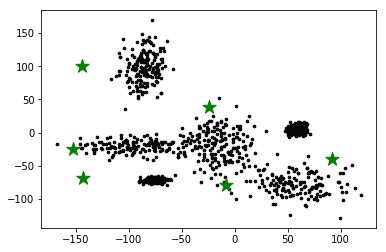

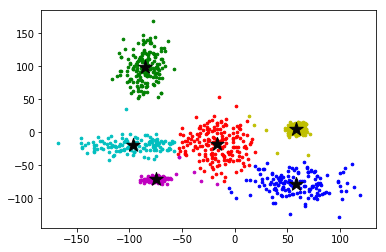

In [72]:
# code from https://github.com/mubaris/friendly-fortnight/blob/master/kmeans-from-scratch-and-sklearn.py

# Number of clusters
k = 6

EPS = 10**(-6)
X = np.array(list(zip(f1, f2)))

C = np.zeros((k, NB_FEATURES))
for i in range(NB_FEATURES):
    C[:,i] = np.random.randint(np.min(X[:,i]), np.max(X[:,i]), size=k)
print("Initial Centroids")
print(C)

# Plotting along with the Centroids
plt.scatter(f1, f2, c='#050505', s=7)
plt.scatter(C[:,0], C[:,1], marker='*', s=200, c='g')

# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)

# Loop will run till the error becomes zero
while error >= EPS:
    # Assigning each value to its closest cluster
    for i in range(len(X)):
        distances = dist(X[i], C, ax=1)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    C_old = np.copy(C)
    # Finding the new centroids by taking the average value
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, C_old, None)

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
    if len(points):
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i%6])
ax.scatter(C[:, 0], C[:, 1], marker='*', s=200, c='#050505')

## Mean-shift clustering

samples intialized


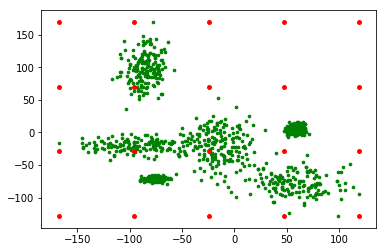

In [64]:
# code from https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/

X = np.array(list(zip(f1, f2)))
sample_x = 5
sample_y = 4
nb_samples = sample_x * sample_y
EPS = 10**(-6)

def initial_samples(sx=sample_x, sy=sample_y):
    x_tmp = np.tile(np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=sx), (sy,1)).flatten()
    y_tmp = np.tile(np.linspace(np.min(X[:,1]), np.max(X[:,1]), num=sy), (sx,1)).transpose().flatten()
    samples = np.array([x_tmp, y_tmp]).transpose()
    return(samples)

samples = initial_samples()
print("samples intialized")

OLD_SAMPLES = np.copy(samples)

fig, ax = plt.subplots()
for i,_ in enumerate(X):
    ax.scatter(X[i][0], X[i][1], s=7, c=colors[1], zorder = 0)
for i,_ in enumerate(samples):
    ax.scatter(samples[i][0], samples[i][1], s=15, c=colors[0], zorder = 2)

---
Now we shift the samples

sample 0 converged
sample 5 converged
sample 10 converged
sample 15 converged


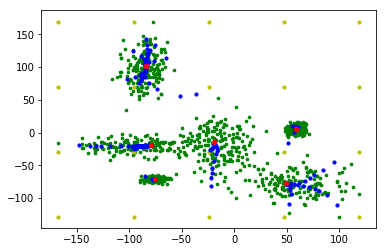

In [75]:
fig, ax = plt.subplots()
samples = np.copy(OLD_SAMPLES)
at_peak = np.full(len(samples), False, dtype=bool)
KERNEL_BANDWIDTH = 2

def compute_kde(p, X):
    weight = 0
    for i,_ in enumerate(X):
        d = dist(p, X[i])
        weight += gaussian_kernel(d, KERNEL_BANDWIDTH)
    return weight

def shift(p):
    shift_coord = np.zeros((NB_FEATURES))
    scale_factor = 0
    for i,_ in enumerate(X):
        # numerator
        d = dist(p, X[i])
        weight = gaussian_kernel(d, KERNEL_BANDWIDTH)
        for j,_ in enumerate(shift_coord):
            shift_coord[j] += X[i][j] * weight
        # demonimator
        scale_factor += weight
    for j,_ in enumerate(shift_coord):
        shift_coord[j] = shift_coord[j] / scale_factor
    return shift_coord

for i,_ in enumerate(samples):
    if i%5==1:
        print("sample {} converged".format(i-1))
    count = 0
    while not at_peak[i]:
        if count==0:
            ax.scatter(samples[i][0], samples[i][1], s=10, c=colors[3], zorder = 1)
        elif count<5 or count%3 == 0:
            ax.scatter(samples[i][0], samples[i][1], s=10, c=colors[2], zorder = 1)
        new_sample = shift(samples[i])
        if np.all(np.abs(new_sample - samples[i]) < EPS):
            at_peak[i] = True
        samples[i] = new_sample
        count += 1

for i,_ in enumerate(X):
    ax.scatter(X[i][0], X[i][1], s=7, c=colors[1], zorder = 0)
for i,_ in enumerate(samples):
    ax.scatter(samples[i][0], samples[i][1], s=15, c=colors[0], zorder = 2)

---
Let us print the clusters now.

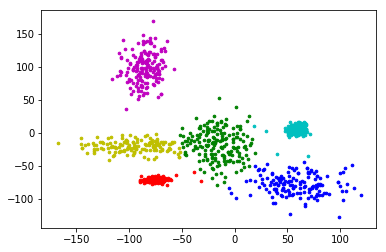

In [68]:
fig, ax = plt.subplots()
sample_parents = np.arange(nb_samples)
parent_found = np.full(len(samples), False, dtype=bool)
for i,s1 in enumerate(samples):
    parent_found[i] = True
    for j,s2 in enumerate(samples):
        if not parent_found[j]:
            if np.all(np.abs(s1 - s2) < EPS*1000):
                parent_found[j] = True
                sample_parents[j] = i
final_samples = list(set(sample_parents))

def closest_sample(p, fs=final_samples, shifts = 1):
    # we shift a few times so that the cluster is more relevant
    p2 = np.copy(p)
    for _ in range(shifts):
        p2 = shift(p2)
    distances = [dist(p2, samples[q]) for q in fs]
    return (fs[np.argmin(distances)])

parents = [closest_sample(p) for p in X]
        
for i,x in enumerate(set(sample_parents)):
    points = np.array([X[j] for j in range(len(X)) if parents[j]==x])
    if (len(points)):
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i%6])